## What can we learn from publically available genetic data?

Your DNA holds a wealth of information about your ancestry, susceptibility to diseases, and complex characteristics including height, weight, facial features, and behavior. Using publically available data from 23andMe, a direct-to-consumer genetics company, we will show how to determine the ancestry of an anonymous sample from 23andMe found online.

Three things you will learn and be able to do by the end of this tutorial:
1. How to understand and analyze genetic data from two different sources (23andMe and 1000 Genomes Project).
2. The basics of principle component analysis, a tool for unsupervised clustering, dimensional reduction, and data exploration.
3. How to predict ancestry from an anonymous genetic data set using principle component analysis.

First, you can download a set of publically-available 23andMe data. This file is about 23Mb in size. We will use the python urllib package (link here) to download the file.

In [1]:
import urllib

u = urllib.URLopener()
u.retrieve("https://s3-eu-west-1.amazonaws.com/dm-23andme-v3/dm_23andme_v3_110219.txt", "dm_23andme_v3_110219.txt")

('dm_23andme_v3_110219.txt', <httplib.HTTPMessage instance at 0x1078043f8>)

We will use the pandas library to load our data as a dataframe and take a look at the shape and content. The file has a number of header lines that start with '#'. We will skip these rows.

In [7]:
import pandas as pd
anon = pd.read_table("../data/dm_23andme_v3_110219.txt", sep = "\t", comment = "#", header = None)

/Users/ps14/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check how many rows and columns the data has, and what the data looks like:

In [8]:
print("The 23andMe datset has {} rows and {} columns.".format(anon.shape[0], anon.shape[1]))
print(anon.head())


The 23andMe datset has 966977 rows and 4 columns.
            0  1       2   3
0   rs4477212  1   72017  AA
1   rs3094315  1  742429  AG
2   rs3131972  1  742584  AG
3  rs12124819  1  766409  --
4  rs11240777  1  788822  AG


For this tutorial, you only need to use about 1000 rows of this dataframe - you can take the first 1,000:

In [9]:
anon = anon.iloc[0:1000,:]

## How is Genetic Data Organized

The human genome is a sequence of over 3 billion letters (called 'bases') consisting of A's, T's, G's, and C's. This 3 billion letter sequence is split up into 23 different segments called chromosomes. The largest, chromosome 1, is nearly 250 million bases long. We have two copies of our genome (one from mom, one from dad), so we each have over 6 billion letters of DNA sequence.

The schematic below shows a single chromosome and how the millions of base pairs are condensed and packaged into the chromosome.


<img src=./0321_DNA_Macrostructure.jpg>

In the dataframe you just printed above, the second and third columns correspond to the chromosome and position. The fourth column contains the two bases at that chromosome and position. The first column is called the rsid and it is an identifier used in databases for genetic variants.

All of this column naming information is in the header of the file we loaded, but we skipped it with the comment = "#" line above.

Let's rename the columns of the dataset accordingly:

In [10]:
anon.columns = ["rsid", "chr", "pos", "genotype"]
print(anon.head())


         rsid chr     pos genotype
0   rs4477212   1   72017       AA
1   rs3094315   1  742429       AG
2   rs3131972   1  742584       AG
3  rs12124819   1  766409       --
4  rs11240777   1  788822       AG


## Working with Publically Available Genetic Data from Three Major Human Populations


Next, we will download samples from three major groups of humans sequenced as part of the 1,000 genomes project to catalog human genetic variation across the globe. These three groups are CEU (Northern Europeans from Utah), YRI (Yoruba in Ibadan, Nigeria) and CHB/JPT (Han Chinese and Japanese in Tokyo).

The first important lesson about dealing with genomic data is that it can get VERY big. The raw data generated in sequencing a single human genome covering the 6 billion or so sites is usually at least 30Gb. By reducing down to only a subset of sites that are known to vary within human populations (23andMe uses about 1 million sites), this can be reduced. The anonymous 23andMe data we are using is only 23Mb.

We will use tabix, a popular tool for indexing and querying large genomic data sets in order extract the data from the sites we are interested in from the 1000 Genomes files. Tabix saves us tons of time and makes large files much more easily accessible - more info on tabix here: http://www.htslib.org/doc/tabix.html.

We will download two files - one is the genetic data itself and one is an index generated by tabix that makes querying fast and low-memory. This file is compressed and about 1Gb (969Mb) in size, so depending on your internet connection it may take a few minutes to download. You don't need to unzip it - if you do decide to unzip it to check the file out, it is about 7Gb unzipped, so don't try to look at the whole thing at once!

You will need to run the command 'pip install --user pytabix' to use tabix in python.

In [ ]:
u = urllib.URLopener()
u.retrieve("ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/paper_data_sets/a_map_of_human_variation/low_coverage/snps/YRI.low_coverage.2010_09.genotypes.vcf.gz", "YRI.low_coverage.2010_09.genotypes.vcf.gz")
u.retrieve("ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/paper_data_sets/a_map_of_human_variation/low_coverage/snps/YRI.low_coverage.2010_09.genotypes.vcf.gz.tbi", "YRI.low_coverage.2010_09.genotypes.vcf.gz.tbi")

In [11]:
import tabix

YRI_file = "../data/YRI.low_coverage.2010_09.genotypes.vcf.gz"
yri = tabix.open(YRI_file)


Genetic coordinates are usually zero-based, meaning that the first base in a sequence will be 'between' position zero and position one. Below, we will check the YRI data set for the rs3094315 variant by querying sites on chromosome 1 betwen position 742428 and 742429 (this will be the 742429th base in the sequence). A simple graphic showing the difference between zero-based vs 1-based coordinates is below, taken from the following biostars post: https://www.biostars.org/p/84686/

Please note, this tutorial has been updated for Python 3, so we use the `__next__()` method of tabix. If you are using Python 2.7 then use `next()` instead! Thanks to Matthew Wipperman from Memorial Sloan Kettering Cancer Center for discovering this and finding the fix!


<img src=./basic_diagram.jpg>

rs3094315 is the second variant in our 23andMe data set and it has also been sequenced in the YRI data set:

In [15]:
rs3094315 = yri.query("1", 742428, 742429)  # an iterator object
print(rs3094315.__next__()

SyntaxError: unexpected EOF while parsing (<ipython-input-15-b51288b5625e>, line 2)

How do we read the output above? As you may have noticed, it is quite a bit different that the way our 23andMe data is organized.

The 1000 Genomes files are stored in VCF (variant call format) files, which is different from the format 23andMe provides, so we will need to do some data-wrangling to make the two work together. 

From left to right, the first five columns encode the chromosome, position, rsid, reference base (this is the letter that we expect to see most of the time), the alternate base (this is the letter that is the 'variant' which is present in some members of the population). More information on the information that is contained in a VCF can be found here: http://www.1000genomes.org/wiki/Analysis/vcf4.0/. This is one of the most common file formats in genetics and much of the additional data besides the genotypes themselves can be used to filter data to improve quality. To take a look at the VCF, you can make a copy of the bgzipped VCF you downloaded, unzip it, and use 'less' on the command line to take a look. The file is almost 7Gb once unzipped.



The final column of the VCF and (the last entry of this list) shows the genotype of each of the 59 YRI samples included in this final. The last 59 entries in the list all follow a similar format for reporting the genotype that is colon separated. For now, we are only interested in the first piece of information which is the genotype (it will be 0|0, 1|0, 0|1, or 1|1).

As you can see above, our anonymous sample's genotype at this site is AG which corresponds to a 1|0 in the format listed above. 0 is the reference (G) and 1 is the alt (A). A few of the YRI samples are 1|1 which means they are AA at this site, while the YRI samples that are 0|0 are GG at this site. Before we go much further, we want to convert our 23andMe data to more closely match the format of the population reference we just downloaded by adding a column showing the genotype in the 0 and 1 format used in the 1000 Genomes VCF file (this is more common than the format 23andMe uses).

In [18]:
def convert_anon_genotype(chr, pos, genotype, vcf_tabix):
    site = vcf_tabix.query(chr, pos - 1, pos)
    try:
        row = site.__next__() # this will throw an error (which is caught by 'except' on the next line) if the site we queried is not in the tabix file
    except StopIteration:
        return None # put None in the dataframe if we are missing this genotype in 1000 Genomes
    ref = row[3]
    alt = row[4]
    if genotype == ref+ref:
        return("0|0")
    elif (genotype == ref+alt) | (genotype == alt+ref):
        return("0|1")
    elif genotype == alt+alt:
        return("1|1")
    else: # missing genotype, or incorrect annotation, we assume ref/ref
        return("0|0")

In [19]:
genotypes_1kg_format = []
for chr, pos, genotype in zip(anon['chr'], anon['pos'], anon['genotype']):
    genotypes_1kg_format.append(convert_anon_genotype(str(chr), pos, genotype, yri))

anon['genotype_1kg_format'] = genotypes_1kg_format
print(anon.head())
print(anon.shape)

         rsid chr     pos genotype genotype_1kg_format
0   rs4477212   1   72017       AA                None
1   rs3094315   1  742429       AG                 0|1
2   rs3131972   1  742584       AG                 0|1
3  rs12124819   1  766409       --                None
4  rs11240777   1  788822       AG                None
(1000, 5)


## Making a Featurespace from our Genotypes

We want to express the genetic data as a feature space with the first goal in mind of predicting ancestry. We will build a dataframe where our rows are the samples (people) and we treat the genotype at each chromosome and position as a separate feature. Since we restricted the anonymous 23andMe sample to the first thousand sites, our dataframe will have two columns describing the population and a name for each sample, plus another 1000 columns (one for each feature).

In [20]:
# make a data frame with one row for each of the YRI samples
yri_genotypes = pd.DataFrame({"sample": ["YRI" + str(i) for i in range(1, 60)], "population": "YRI"})
print(yri_genotypes.head())

  population sample
0        YRI   YRI1
1        YRI   YRI2
2        YRI   YRI3
3        YRI   YRI4
4        YRI   YRI5


To get the genotype from each person, we will write a function that uses pytabix:

In [23]:
# extract genotype information for a set of sites
def extract_genotype(chr, pos, vcf_tabix):
    site = vcf_tabix.query(chr, pos - 1, pos)
    try:
        g = site.__next__()[9:]
    except StopIteration:
        return None # put None in the dataframe if we are missing this genotype in 1000 Genomes
    g = [i.split(":")[0] for i in g]  # if present in 1000 genomes, get the genotypes
    return(g)
    
    
    

In [24]:
for rsid, chr, pos in zip(anon['rsid'], anon['chr'], anon['pos']):
    g = extract_genotype(str(chr), pos, yri)
    yri_genotypes[rsid] = g

In [25]:
print("The dataframe including all of the samples from the YRI population has {} samples and {} genotypes.".format(yri_genotypes.shape[0], yri_genotypes.shape[1] - 2))

The dataframe including all of the samples from the YRI population has 59 samples and 1000 genotypes.


All of the columns with 'None' are sites that were sequenced by 23andMe, but not present in our YRI data set. Later, we will discard all of the sites where we have missing data in any of our populations.

In [26]:
print(yri_genotypes.iloc[0:10, 0:7])

  population sample rs4477212 rs3094315 rs3131972 rs12124819 rs11240777
0        YRI   YRI1      None       0|1       0|1       None       None
1        YRI   YRI2      None       1|1       1|0       None       None
2        YRI   YRI3      None       1|0       1|0       None       None
3        YRI   YRI4      None       0|1       0|1       None       None
4        YRI   YRI5      None       1|0       1|0       None       None
5        YRI   YRI6      None       1|0       0|0       None       None
6        YRI   YRI7      None       0|1       0|1       None       None
7        YRI   YRI8      None       0|0       0|0       None       None
8        YRI   YRI9      None       1|1       1|1       None       None
9        YRI  YRI10      None       1|1       1|0       None       None


Now, we will download data sets and make data frames for the CEU (European from Utah) and CHB/JPT (Han Chinese/Japanese). Again, curl or wget should be used from the command line to download these files and the tabix indexes:

In [ ]:
u = urllib.URLopener()
u.retrieve("ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/paper_data_sets/a_map_of_human_variation/low_coverage/snps/CEU.low_coverage.2010_09.genotypes.vcf.gz", "CEU.low_coverage.2010_09.genotypes.vcf.gz")
u.retrieve("ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/paper_data_sets/a_map_of_human_variation/low_coverage/snps/CEU.low_coverage.2010_09.genotypes.vcf.gz.tbi", "CEU.low_coverage.2010_09.genotypes.vcf.gz.tbi")
u.retrieve("ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/paper_data_sets/a_map_of_human_variation/low_coverage/snps/CHBJPT.low_coverage.2010_09.genotypes.vcf.gz", "CHBJPT.low_coverage.2010_09.genotypes.vcf.gz")
u.retrieve("ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/pilot_data/paper_data_sets/a_map_of_human_variation/low_coverage/snps/CHBJPT.low_coverage.2010_09.genotypes.vcf.gz.tbi", "CHBJPT.low_coverage.2010_09.genotypes.vcf.gz.tbi")


In [29]:
# europeans from utah
CEU_file = "../data/CEU.low_coverage.2010_09.genotypes.vcf.gz"
ceu = tabix.open(CEU_file)

number_ceu_samples = len(ceu.query("1", 742428, 742429).__next__()[9:])

ceu_genotypes = pd.DataFrame({"sample": ["CEU" + str(i) for i in range(1, number_ceu_samples + 1)], "population": "CEU"})

# Han chinese and Japanese
CHBJPT_file = "../data/CHBJPT.low_coverage.2010_09.genotypes.vcf.gz"
chbjpt = tabix.open(CHBJPT_file)

number_chbjpt_samples = len(chbjpt.query("1", 742428, 742429).__next__()[9:])

chbjpt_genotypes = pd.DataFrame({"sample": ["CHBJPT" + str(i) for i in range(1, number_chbjpt_samples + 1)], "population": "CHBJPT"})


In [30]:
for rsid, chr, pos in zip(anon['rsid'], anon['chr'], anon['pos']):
    yri_genotypes[rsid] =  extract_genotype(str(chr), pos, yri)
    ceu_genotypes[rsid] =  extract_genotype(str(chr), pos, ceu)
    chbjpt_genotypes[rsid] =  extract_genotype(str(chr), pos, chbjpt)

At this point, we have three separate dataframes from our three populations of interest containing their genotype at 1000 different locations. Our goal is to see how well we can separate the samples into populations based only on their genetic information, ignoring the original population labels.

In [36]:
genotypes = yri_genotypes.copy()
genotypes = genotypes.append(ceu_genotypes, ignore_index=True)
genotypes = genotypes.append(chbjpt_genotypes, ignore_index=True)

print("Now the genotypes data frame has {} samples and {} genotypes".format(genotypes.shape[0], genotypes.shape[1]-2))

Now the genotypes data frame has 179 samples and 1000 genotypes


## Unsupervised Clustering using Principal Component Analysis

To try to separate our data into populations, we will use principal component analysis (PCA), an unsupervised method that is very useful for combining information from large feature spaces into a smaller set of features that capture a large proportion of the variance between samples.

PCA takes a high dimensional feature space (in our case, 10 features) and creates a 'principal component' that captures the variance between samples using a linear combination of all of the features. Our data can be imagined as a cloud of points in high dimensional space. The first principal component is a line through this high dimensional space. The second principal component must be orthogonal (at a 90 degree angle) to the first principal component and is constructed to capture the second largest amount of variance.

Another way of thinking about principal components is as a 'projection' or a 'shadow' of the high dimensional data into a low dimension space. The figure below shows an example of visualizing a four dimensional feature space in two dimensions.

This figure comes from a scikit-learn tutorial using data from the very popular Iris dataset: http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

<img src=./plot_pca_vs_lda_001.png>

Now, we will use PCA on our genetic data set to try to visualize the variance between our samples. We will use the scikit-learn library for PCA. Below, we convert the genotype values to continuous values. Samples that have two copies of the reference letter are given 0, one copy of reference and one copy of alternate is given 0.5, and two copies the alternate is given 1.0. Also, we will drop any variants that have 'None' in our population panel from 1000 Genomes because they will not be informative.

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

genotypes_only = genotypes.copy().iloc[:, 2:]  # we make a copy here, otherwise pandas will gripe at us!
genotypes_only[genotypes_only == "1|1"] = 1
genotypes_only[genotypes_only == "0|1"] = 0.5
genotypes_only[genotypes_only == "0/1"] = 0.5
genotypes_only[genotypes_only == "1|0"] = 0.5
genotypes_only[genotypes_only == "0|0"] = 0.0

# remove variants with None
genotypes_only = genotypes_only.dropna(axis=1)


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

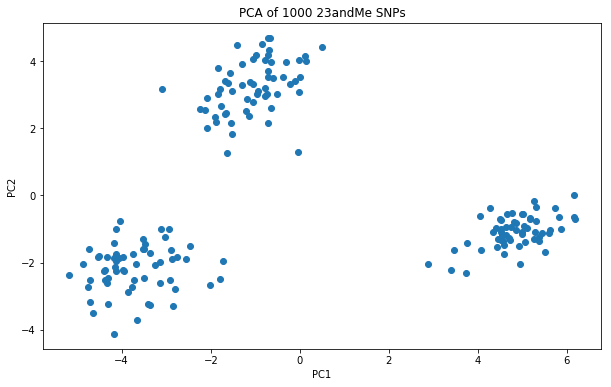

In [39]:
pca.fit(genotypes_only)
pc = pca.transform(genotypes_only)

plt.figure(figsize=(10,6))
plt.scatter(pc[:, 0], pc[:, 1])
plt.title('PCA of 1000 23andMe SNPs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


Using less than one thousand sites from our 23andMe data set (remember, this is only a fraction of the nearly 1 million sites total in the 23andMe data set), we see that our data is separated very cleanly into three clusters. If we add our population labels back on, we can see that these clusters represent the three populations we began with. One of the most powerful parts of PCA for this particular analysis is that we don't need to specify the number of clusters we are looking for to begin with.

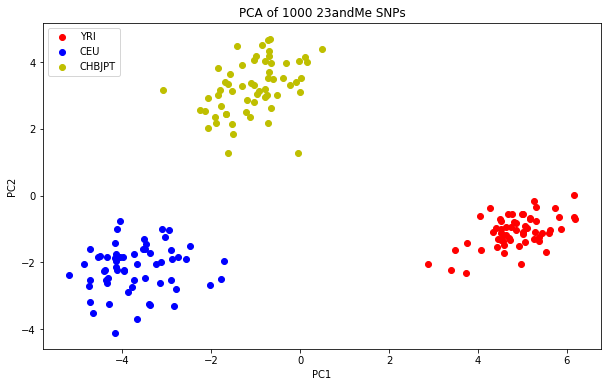

In [40]:
import numpy as np

plt.figure(figsize=(10,6))

for c, pop in zip("rby", ["YRI", "CEU", "CHBJPT"]):
    plt.scatter(pc[np.where(genotypes['population'] == pop), 0], pc[np.where(genotypes['population'] == pop), 1], c = c, label = pop)
plt.title('PCA of 1000 23andMe SNPs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'upper left')
plt.show()

One of the most important things analysis also tells us is that if we are interested in learning ANYTHING from our genetic data besides where people's ancestors come from, we need to control for population structure (i.e. use population/ancestry as a covariate). When we are trying to understand the role that genetics plays in susceptibility to common diseases (e.g. diabetes, obesity, heart disease, hereditary cancers), we have to ensure that our cases (people with the disease) and controls (people without the disease) don't differ greatly in their ancestry.

Another interesting observation from the PCA plot is that the Yoruba cluster (red) is separated from the Chinese/Japanese and European cluster in the first principal component. This is a reflection of the origin of modern humans in Africa and the subsequent migration out of Africa and into Europe/Asia. The second principal component then reflects the later migrations resulting in genetic differences betweeen the Chinese/Japanese cluster and the European cluster.

Where does our anonymous 23andMe sample fall in this map? The 23andMe data format is different from the VCF, so we will write a quick function to check the VCF (using tabix) to map the 23andMe genotypes, which are reported as letters, to the 0|0, 0|1, and 1|1 that we are used to by now.

In [41]:
# keep only the genotypes used in our PCA above
anon = anon.loc[anon['rsid'].isin(genotypes_only.columns.values), :]  # only keep the 23andMe data where we have no missing data in 1000 genomes

anon_genotypes = anon.copy()["genotype_1kg_format"]

anon_genotypes[anon_genotypes == "1|1"] = 1
anon_genotypes[anon_genotypes == "0|1"] = 0.5
anon_genotypes[anon_genotypes == "1|0"] = 0.5
anon_genotypes[anon_genotypes == "0|0"] = 0.0
#anon_genotypes[anon_genotypes == None] = 0.0
anon_genotypes = anon_genotypes.reshape(1,-1) # reshape, otherwise sci-kit learn will throw a deprecation warning

# assume any missing data in our 23andme sample is ref/ref
#anon_genotypes[anon_genotypes is None] = "0|0"

anon_pca = pca.transform(anon_genotypes)  # pca was fit on the 1000 genomes data and we use it to transform the anonymous genotypes

/Users/ps14/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In the first line above, we discard any 23andMe sites that were not also part of the 1000 genomes site as we have to have the same underlying data between the two sets (anonymous 23andMe and 1000 genomes) in order to compute the value of the anonymous sample in principle component space. Furthermore, adding additional sites that were

In [42]:
print(anon.head())

        rsid chr     pos genotype genotype_1kg_format
1  rs3094315   1  742429       AG                 0|1
2  rs3131972   1  742584       AG                 0|1
6  rs4970383   1  828418       CC                 0|0
7  rs4475691   1  836671       CC                 0|0
8  rs7537756   1  844113       AA                 0|0


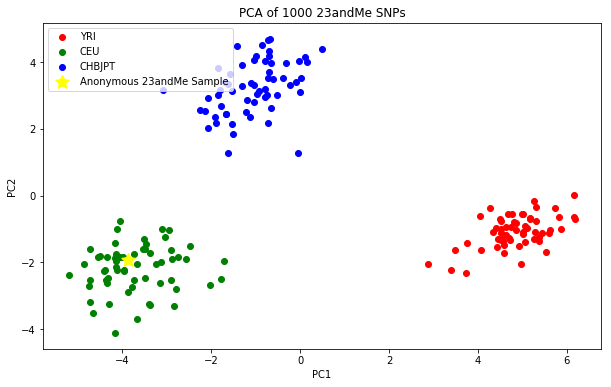

In [43]:
plt.figure(figsize=(10,6))

for c, pop in zip("rgb", ["YRI", "CEU", "CHBJPT"]):
    plt.scatter(pc[np.where(genotypes['population'] == pop), 0], pc[np.where(genotypes['population'] == pop), 1], c = c, label = pop)

# take the code above and add in the anonymous sample

plt.scatter(anon_pca[0,0], anon_pca[0,1], c = "yellow", label = "Anonymous 23andMe Sample", marker = (5,1,0), s = 200)

plt.title('PCA of 1000 23andMe SNPs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'upper left')
plt.show()

As we can see in the plot above, our anonymous sample (the yellow star) is squarely in the European cluster. In practice, a population reference panel has far more sub-populations than the three used here. This tutorial shows how to do a simple ancestry analysis with a few snippets of python, but we could take it a step further and predict ancestry using a more sophisticated model. 

The final release of the 1000 Genomes data set has data from 26 different populations (http://www.1000genomes.org/category/population/). In this case, the genomic data from 1000 Genomes serves as the training data and you can build a classifier to predict proportional ancestry (e.g. 1/2 Irish, 1/2 Han Chinese) using a Gaussian Mixture Model or K-Nearest-Neighbors for instance.

Beyond ancestry, genomic data can be used to predict disease risk, side effects to pharmaceuticals, and even to construct a model of your face (https://www.newscientist.com/article/mg22129613-600-genetic-mugshot-recreates-faces-from-nothing-but-dna/). 

Check back here for more free tutorials on analyzing genetic data using Python, or sign up for one of our Data Science courses!

###Background

<img src=./sanger_headshot_PJS.JPG width=150 align=left>

<p style="clear:left">Patrick is a PhD Student in Mathematical Genomics and Medicine at the University of Cambridge and the Wellcome Trust Sanger Institute. Before his PhD, Patrick studied Applied Mathematics and Quantitative Biology at the University of North Carolina, Chapel Hill.</p>